In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
batch_size = 32
img_height=256
img_width=256



In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory('D:/gesture/train',validation_split = 0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory('D:/gesture/train',validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

class_names = train_ds.class_names
print("Class name: ", class_names)
print("Total classes: ", len(class_names))

Found 169231 files belonging to 29 classes.
Using 135385 files for training.
Found 169231 files belonging to 29 classes.
Using 33846 files for validation.
Class name:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total classes:  29


In [3]:
print(type(train_ds) )

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


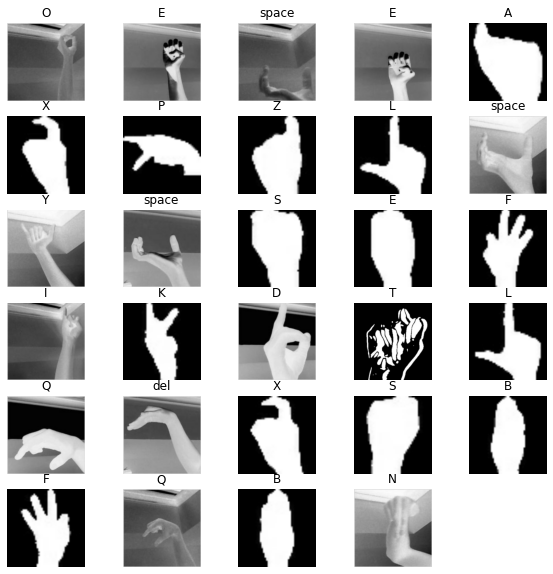

In [4]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(6,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM

model = Sequential([
    layers.Rescaling(1./255,input_shape=(256,256,3)),
    layers.Conv2D(16, 3, activation='relu'), #padding ≠ same, as output value size ≠ input volume size
    layers.MaxPooling2D(), #downsampled

    layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding = 'same'),
    layers.MaxPooling2D(),

    layers.Flatten(),

#model.add(Dropout(0.2))
    layers.Dense(128,activation ="relu"),
#model.add(Dropout(0.3))
    layers.Dense(29,activation ="softmax")
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        1

In [6]:
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten



# model = Sequential()
# model.add(LSTM(units=(100),input_shape=(64,192)))
# model.add(Dense(26))

# model.summary()

In [ ]:

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, batch_size=32, validation_batch_size=32, validation_data=test_ds,epochs=3)

Epoch 1/3
  31/4231 [..............................] - ETA: 39:16 - loss: 3.6369 - accuracy: 0.1280

In [ ]:
 model.save('Best_model.h5')

In [ ]:
import numpy as np
import cv2
import time
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

model = keras.models.load_model(r"Best_model.h5")

background = None
accumulated_weight = 0.5

ROI_top = 50
ROI_bottom = 350
ROI_right = 100
ROI_left = 350

def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)
    
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    
     #Fetching contours in the frame (These contours can be of hand or any other object in foreground) …

    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If length of contours list = 0, means we didn't get any contours...
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand 
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment(max contour) and the thresholded image of hand...
        return (thresholded, hand_segment_max_cont)


word_dict = class_names


cam = cv2.VideoCapture(0)

num_frames =0
while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    
    
    time.sleep(0.2) # increase execution of program
    
    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            time.sleep(0.2)
            thresholded = cv2.resize(thresholded, (256, 256))
            thresholded = cv2.cvtColor(thresholded,cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.putText(frame_copy, "Hand sign recognition_ _ _",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)


    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()